In [622]:
!wget https://clark.physics.illinois.edu/stats.py
import stats

--2024-02-29 18:17:39--  https://clark.physics.illinois.edu/stats.py
Resolving clark.physics.illinois.edu (clark.physics.illinois.edu)... 18.220.149.166
Connecting to clark.physics.illinois.edu (clark.physics.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1979 (1.9K)
Saving to: ‘stats.py.25’

stats.py.25         100%[===================>]   1.93K  --.-KB/s    in 0s      

2024-02-29 18:17:39 (629 MB/s) - ‘stats.py.25’ saved [1979/1979]



In [623]:
import numpy as np
import pylab as plt
import pandas as pd
import random as rnd
import math
import gzip
import sys
import os
import time
from collections import defaultdict
from numba import jit


In [638]:
# TESTING 1
@jit
def FlipSpin(x, y, matrix):
	if matrix[x][y] == 0:
		matrix[x][y] = 1
	else:
		matrix[x][y] = 0
	return matrix

@jit
def deltaE(x, y, matrix):
	dirs = [(-1, 0), (1, 0), (0, 1), (0, -1)]
	E = 0
	for coordPair in dirs:
		newX = (x + coordPair[0]) % len(matrix)
		newY = (y + coordPair[1]) % len(matrix[0])
		if matrix[x][y] == matrix[newX][newY]:
			E -= 2
		else:
			E += 2
	return E

@jit
def Energy(c, flipX, flipY, oldE):
	rows, cols = len(c), len(c[0])
	if oldE is not None:
		return oldE + deltaE(flipX, flipY, c)
	E = 0
	for row in range(rows):
		for col in range(cols):
			# right
			if col + 1 < cols:
				if c[row][col] == c[row][col + 1]:
					E += -1
				else:
					E += 1
			elif col == cols - 1:
				if c[row][col] == c[row][0]:
					E += -1
				else:
					E += 1
			# down
			if row + 1 < rows:
				if c[row][col] == c[row + 1][col]:
					E += -1
				else:
					E += 1
			elif row == rows - 1:
				if c[row][col] == c[0][col]:
					E += -1
				else:
					E += 1
	return E

print("Starting with a 3 x 3 grid of spin ups")
initialMatrix = np.array([
	[1, 1, 1],
	[1, 1, 1],
	[1, 1, 1]
])
e = Energy(initialMatrix, None, None, None)
flipX, flipY = np.random.randint(0, initialMatrix.shape[0]), np.random.randint(0, initialMatrix.shape[1])
newMatrix = FlipSpin(flipX, flipY, initialMatrix.copy())
print(newMatrix)
# print(deltaE(flipX, flipY, initialMatrix))
print(f"Actual: {Energy(newMatrix, flipX, flipY, e)}")
# print(f"Expected: {Energy(newMatrix, None, None, None)}")

Starting with a 3 x 3 grid of spin ups
[[1 1 1]
 [1 1 0]
 [1 1 1]]
Actual: -10


In [625]:
# #Actual stuff
# initialMatrix = np.array([
# 	[-1, -1, -1],
# 	[-1, -1, -1],
# 	[-1, -1, -1]
# ])
# e = Energy(initialMatrix, None, None, None)
# print(e)
# initialMatrix = np.array([
# 	[-1, -1, -1],
# 	[-1, 1, -1],
# 	[-1, -1, -1]
# ])
# e = Energy(initialMatrix, None, None, None)
# print(e)
# initialMatrix = np.array([
# 	[-1, -1, -1],
# 	[-1, 1, -1],
# 	[-1, -1, 1]
# ])
# e = Energy(initialMatrix, None, None, None)
# print(e)


In [639]:
initialMatrix = np.array([
	[-1, -1, -1],
	[-1, -1, -1],
	[-1, -1, -1]
])
e = Energy(initialMatrix, None, None, None)
print(e)

flipX, flipY = 1, 1
newMatrix = FlipSpin(flipX, flipY, initialMatrix.copy())
e = Energy(newMatrix, flipX, flipY, e)
print(e)

flipX, flipY = 2, 2
intitialMatrix = newMatrix
newMatrix = FlipSpin(flipX, flipY, initialMatrix.copy())
print(Energy(newMatrix, flipX, flipY, e))

# print(deltaE(flipX, flipY, initialMatrix))
# print(f"Expected: {Energy(newMatrix, None, None, None)}")

-18
-10
-2


In [627]:
@jit(nopython=True)
def binary_string_to_int(binary_str):
    result = 0
    for bit in binary_str:
        result = (result << 1) | (bit == '1')
    return result

def generateCombinations(currBinString, maxLen, combinations):
	if len(currBinString) == maxLen:
		combinations.append(currBinString.copy())
		return
	for bit in [0, 1]:
		currBinString.append(bit)
		generateCombinations(currBinString, maxLen, combinations)
		currBinString.pop()

def TheoreticalMCMC(n, temp):
	combinations = []
	generateCombinations([], n*n, combinations)
	configurations = []
	probabilities = []
	for combo in combinations:
		c = np.reshape(combo, (n, n))
		prob = np.exp(-(1/temp) * Energy(c, None, None, None)) 
		binary_str = ''
		for spin in c.flatten():
			binary_str += '1' if spin else '0'
		convertedNum = binary_string_to_int(binary_str)
		configurations.append(convertedNum)
		probabilities.append(prob)
	
	total_prob = np.sum(probabilities)
	normalized_probabilities = []
	for prob in probabilities:
		normalized_probabilities.append(prob / total_prob)
		
	return configurations, normalized_probabilities


In [628]:
@jit(nopython=True)
def binary_string_to_int(binary_str):
    result = 0
    for bit in binary_str:
        result = (result << 1) | (bit == '1')
    return result

# Find the magnetization squared
	# take a final state
	# M = # of spin up - # spin down
	# N = # of spins(n*n)
	# M^2 = (M/N)^2
@jit(nopython=True)
def magnetization_squared(finalConfigurationMatrix):
    count_ones = np.count_nonzero(finalConfigurationMatrix == 1)
    count_zeros = np.count_nonzero(finalConfigurationMatrix == 0)
    M = count_ones - count_zeros
    N = finalConfigurationMatrix.shape[0] * finalConfigurationMatrix.shape[1]
    return (M/N)**2

@jit(nopython=True)
def MCMC(n, temp):
	c = np.ones((n, n))	
	e = Energy(c, None, None, None) # c, flipX, flipY, oldE
	energies = np.zeros(10000-20, dtype=np.int64)
	configurations = np.zeros(10000-20, dtype=np.int64)
	magnetizations_sqred = np.zeros(10000-20, dtype=np.float64)
	for sweep in range(10000):
		for i in range(n*n):
			flipX, flipY = np.random.randint(0, c.shape[0]), np.random.randint(0, c.shape[1])
			cP = FlipSpin(flipX, flipY, c.copy())
			eP = Energy(cP, flipX, flipY, e)
			r = np.random.rand()
			acceptProb = np.exp(-eP/temp) / np.exp(-e/temp)
			if acceptProb > r:
				c = cP
				e = eP
		if sweep >= 20:
			energies[sweep - 20] = e
			magnetizations_sqred[sweep - 20] = magnetization_squared(c)
			binary_str = ''
			for spin in c.flatten():
				binary_str += '1' if spin else '0'
			convertedNum = binary_string_to_int(binary_str)
			configurations[sweep - 20] = convertedNum
			
	return c, energies, magnetizations_sqred, configurations

In [629]:
# finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, 10)
# # print(Energy(finalMatrix, None, None, None))
# print(energies)

# c = np.ones((27, 27))
# print(Energy(c, None, None, None))
# # print(np.random.randint(0, c.shape[0]), np.random.randint(0, c.shape[1]))
# # print(c.shape[0], c.shape[1])

# # energies = np.zeros(10000-20, dtype=np.int64)


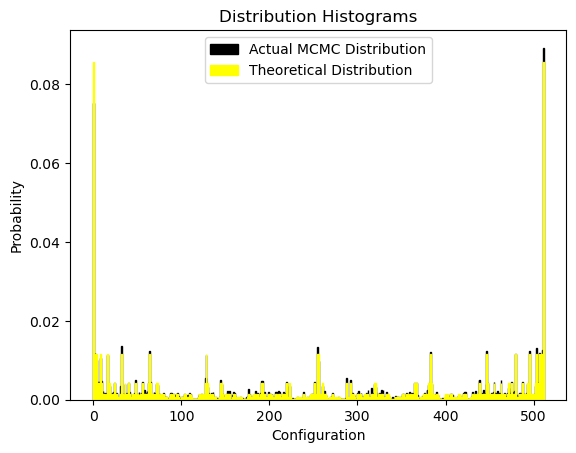

In [630]:
# MCMC = Calculated Distribution of Histogram found from MonteCarlo method, TheoreticalMCMC = Actual Real Distribution
finalMatrix, energies, magnetizations_sqred, configurations = MCMC(3, 4)
configurations1, normalized_probabilities = TheoreticalMCMC(3, 4)

# Get the normalized frequency = probability in this case for the unique configs for the MCMC
unique_configurations, configuration_counts = np.unique(configurations, return_counts=True)
probabilities = np.zeros(len(unique_configurations))
for i in range(len(unique_configurations)):
    probabilities[i] = configuration_counts[i] / len(configurations)

# Plot
plt.bar(unique_configurations, probabilities, width=1, color='black', edgecolor='black', label='Actual MCMC Distribution')
plt.bar(configurations1, normalized_probabilities, width=1, color='yellow', edgecolor='yellow', label='Theoretical Distribution')
plt.xlabel('Configuration')
plt.ylabel('Probability')
plt.title('Distribution Histograms')
plt.legend()

Page 2 Below: Measuring the Ising Model

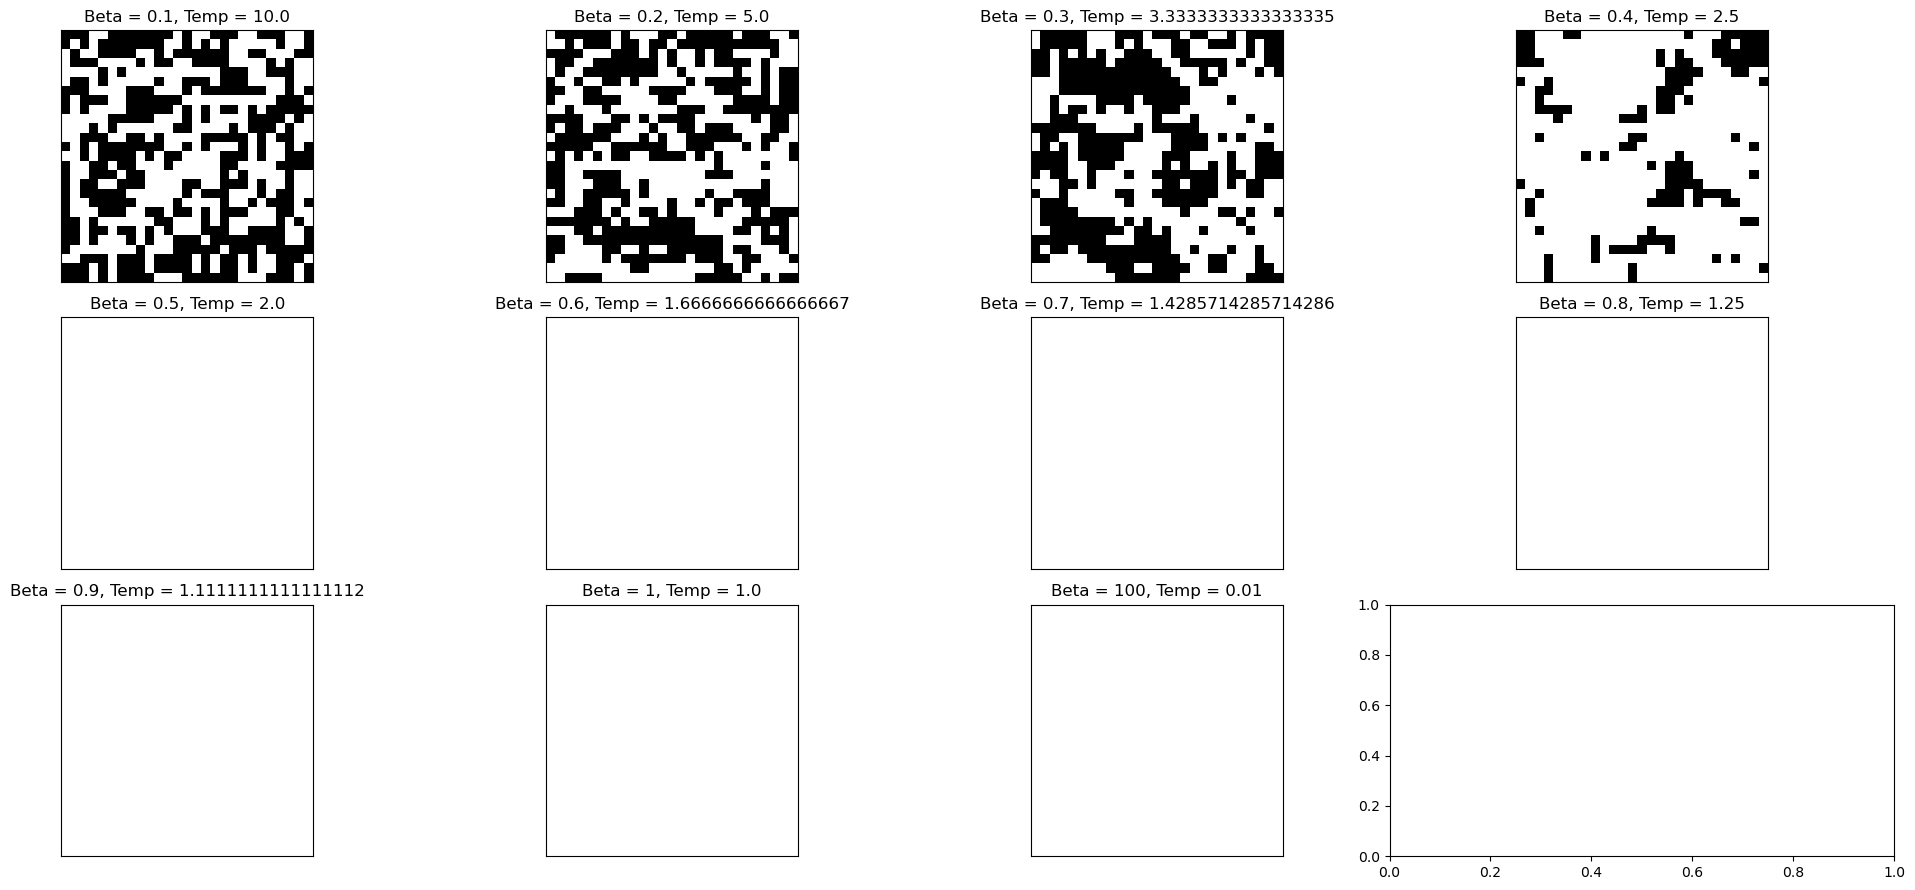

In [631]:
# 1. Generate Prototypical snapshots with pylab.matshow()
'''
    What I expect to see: At high betas = low temperatures so that means that we have more stable configurations so the matshows should be mostly the same color,
    if temp is high = beta is low so that means we will see more randomness in colors.
'''
betaVals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
fig, axes = plt.subplots(3, 4, figsize=(20, 9))
for idx, beta in enumerate(betaVals):
      temp = 1 / beta
      finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
      ax = axes[idx // 4, idx % 4]
      ax.matshow(finalMatrix, cmap='binary') # 1 = white, 0 = black
      ax.set_title(f'Beta = {beta}, Temp = {temp}')
      ax.set_xticks([])
      ax.set_yticks([])
plt.tight_layout()
plt.show()

In [632]:
# finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, 10)
# print(finalMatrix)


In [633]:
# temp = 1 / 0.1
# finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
# print(Energy(finalMatrix, None, None, None))
# print(energies)


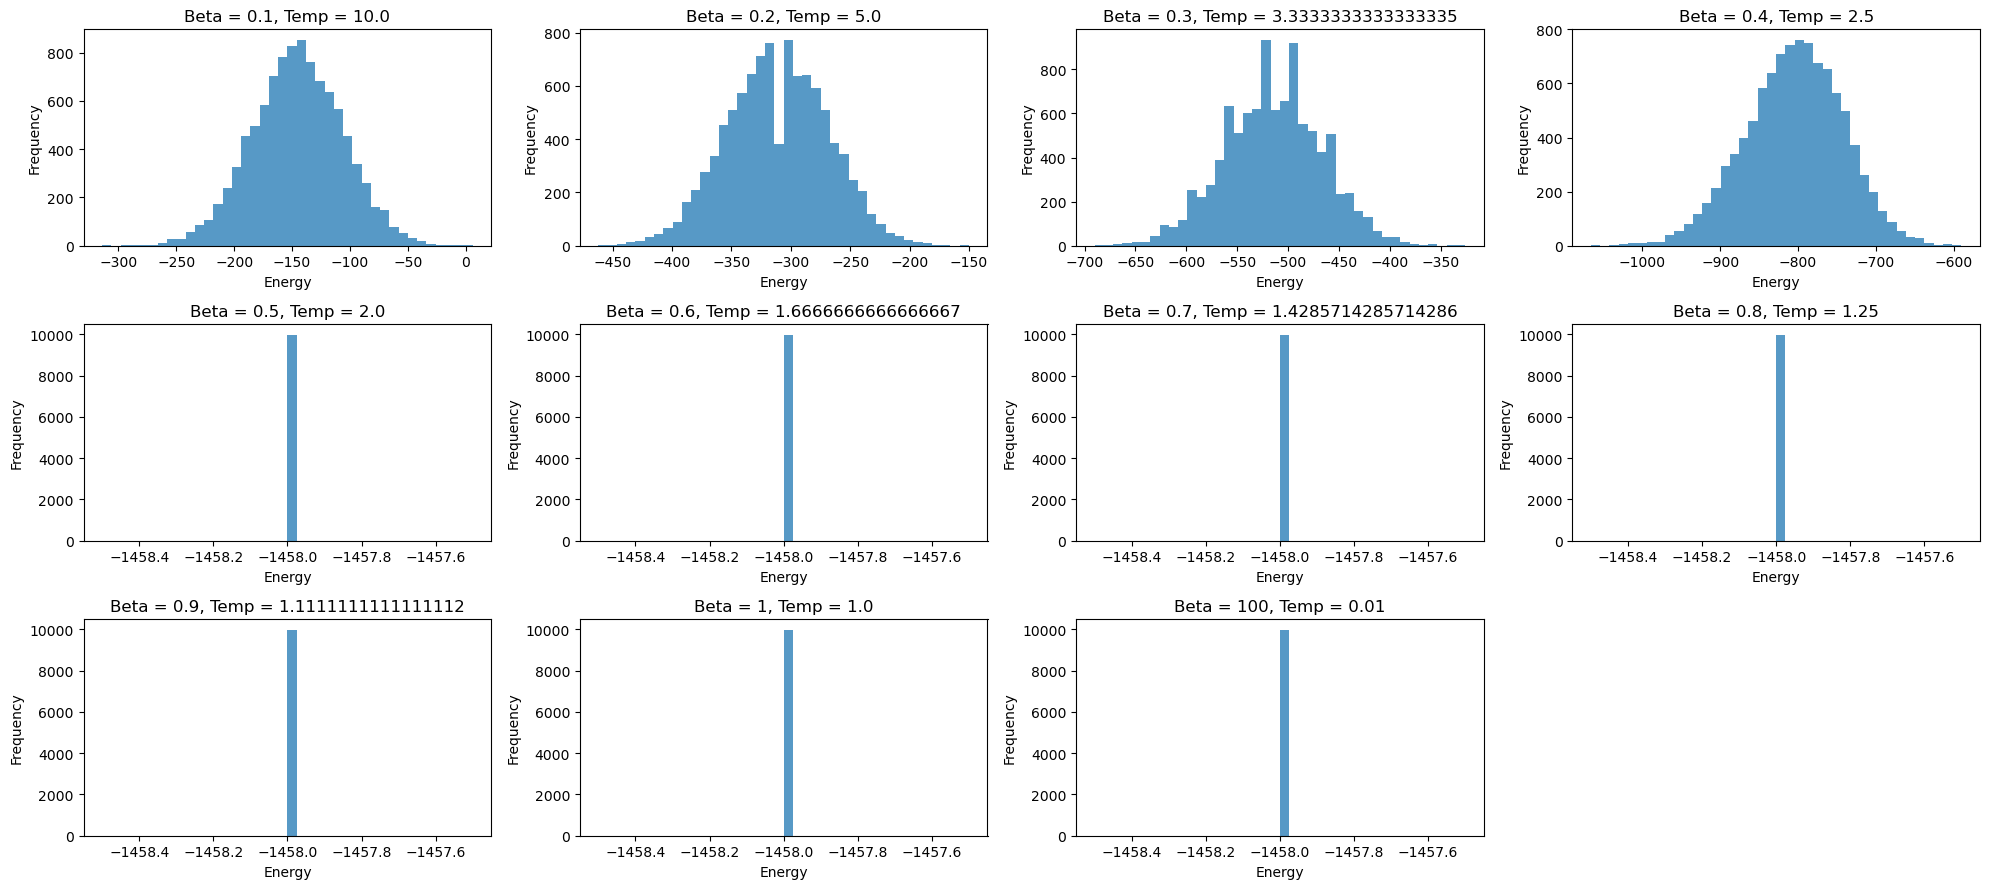

In [637]:
#2. Generating a Histogram of P(E)
betaVals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
plt.figure(figsize=(20, 9))
for idx, beta in enumerate(betaVals):
    temp = 1 / beta
    finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
    plt.subplot(3, 4, idx + 1)
    # plt.bar(unique_energies, energy_counts, width=1, color='blue', edgecolor='blue')
    plt.hist(energies, bins=40, alpha=0.75)
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.title(f'Beta = {beta}, Temp = {temp}')
plt.tight_layout()
plt.show()

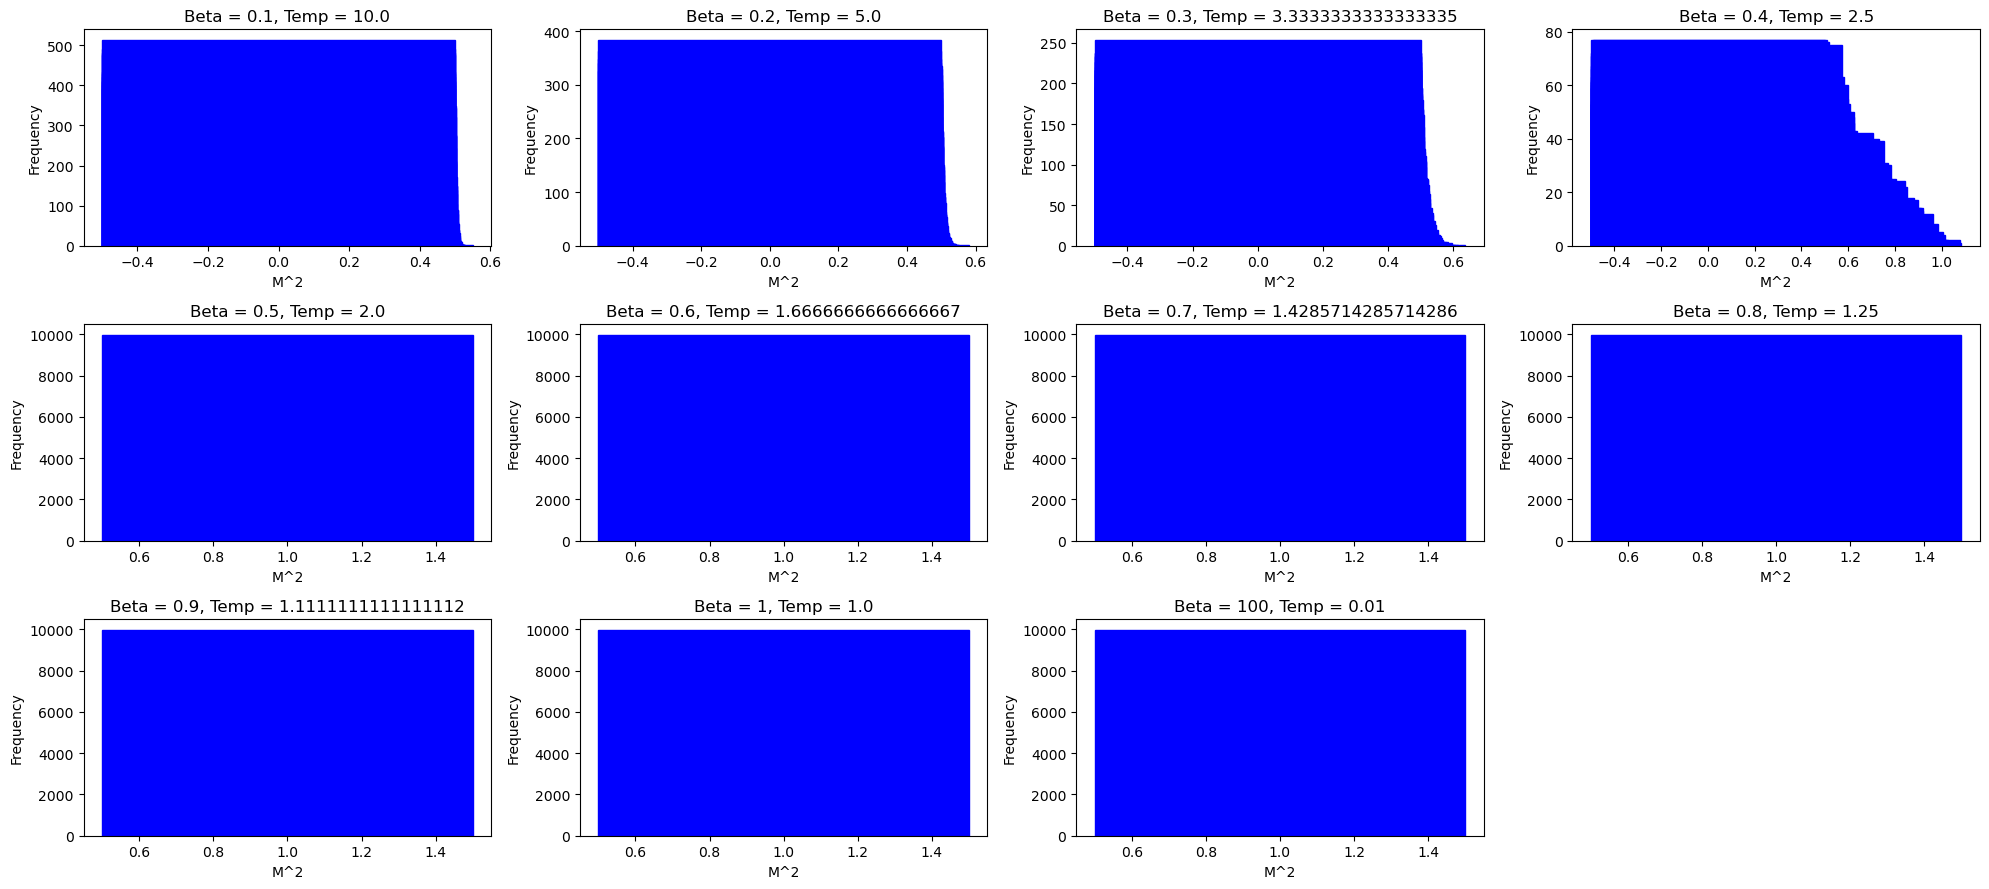

In [635]:
# Histogram of P(M^2)
betaVals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
plt.figure(figsize=(20, 9))
for idx, beta in enumerate(betaVals):
    temp = 1 / beta
    finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
    magnetizations, magnetization_counts = np.unique(magnetizations_sqred, return_counts=True)
    plt.subplot(3, 4, idx + 1)
    plt.bar(magnetizations, magnetization_counts, width=1, color='blue', edgecolor='blue')
    plt.xlabel('M^2')
    plt.ylabel('Frequency')
    plt.title(f'Beta = {beta}, Temp = {temp}')
plt.tight_layout()
plt.show()